In [1]:
library(SparkR)
library(ggplot2)


Attaching package: 'SparkR'


The following objects are masked from 'package:stats':

    cov, filter, lag, na.omit, predict, sd, var, window


The following objects are masked from 'package:base':

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union



Attaching package: 'ggplot2'


The following object is masked from 'package:SparkR':

    expr




In [1]:
import findspark
findspark.init()

In [2]:
sparkR.session()
crsp <- read.df("C:/Users/jack_/Desktop/Big Data Project/updated datasets/Cancer Mortality by State.csv", "csv", inferSchema = "true", header = "true", )

Spark package found in SPARK_HOME: C:\Users\jack_\Desktop\spark-3.0.0-preview2-bin-hadoop2.7



Launching java with spark-submit command C:\Users\jack_\Desktop\spark-3.0.0-preview2-bin-hadoop2.7/bin/spark-submit2.cmd   sparkr-shell C:\Users\jack_\AppData\Local\Temp\RtmpMJ61y4\backend_port6aa06e856a7f 


Warning message in sparkR.session():
"Version mismatch between Spark JVM and SparkR package. JVM version was 3.0.0-preview2 , while R package version was 2.4.5"


Java ref type org.apache.spark.sql.SparkSession id 1 

In [127]:
createOrReplaceTempView(crsp, "crsp")
mr <- sql("select STATE as csa, RATE from crsp where YEAR = 2014")
createOrReplaceTempView(mr, 'mr')
lcd = sql("select case when csa = 'WA' then 'West' 
when csa = 'OR' then 'West'
when csa = 'ID' then 'West'
when csa = 'WY' then 'West'
when csa = 'MT' then 'West'
when csa = 'CA' then 'West'
when csa = 'NV' then 'West'
when csa = 'AZ' then 'West'
when csa = 'UT' then 'West'
when csa = 'CO' then 'West'
when csa = 'AK' then 'West'
when csa = 'HI' then 'West'
when csa = 'NM' then 'West'
when csa = 'NE' then 'Mid-West'
when csa = 'KS' then 'Mid-West'
when csa = 'MO' then 'Mid-West'
when csa = 'IA' then 'Mid-West'
when csa = 'WI' then 'Mid-West'
when csa = 'MN' then 'Mid-West'
when csa = 'SD' then 'Mid-West'
when csa = 'ND' then 'Mid-West'
when csa = 'IL' then 'Mid-West'
when csa = 'IN' then 'Mid-West'
when csa = 'OH' then 'Mid-West'
when csa = 'MI' then 'Mid-West'
when csa = 'TX' then 'South'
when csa = 'OK' then 'South'
when csa = 'AR' then 'South'
when csa = 'LA' then 'South'
when csa = 'MS' then 'South'
when csa = 'AL' then 'South'
when csa = 'GA' then 'South'
when csa = 'FL' then 'South'
when csa = 'TN' then 'South'
when csa = 'KY' then 'South'
when csa = 'WV' then 'South'
when csa = 'VA' then 'South'
when csa = 'NC' then 'South'
when csa = 'SC' then 'South'
when csa = 'MD' then 'South'
when csa = 'DC' then 'South'
when csa = 'DE' then 'South'
when csa = 'PA' then 'North-East'
when csa = 'NJ' then 'North-East'
when csa = 'CT' then 'North-East'
when csa = 'RI' then 'North-East'
when csa = 'NY' then 'North-East'
when csa = 'VT' then 'North-East'
when csa = 'MA' then 'North-East'
when csa = 'NH' then 'North-East'
when csa = 'ME' then 'North-East'
end as Region, csa, RATE from mr")
createOrReplaceTempView(lcd, "lcd_by_reg")
lcd_cancer_by_region = sql("select Region, avg(RATE) as Cancer_AVG from lcd_by_reg group by Region")
createOrReplaceTempView(lcd_cancer_by_region, "cancer_avg_by_reg")
lcdr = collect(lcd_cancer_by_region)
collect(lcd_cancer_by_region)

,Region,Cancer_AVG
,<chr>,<dbl>
1,South,175.0250
2,West,148.4154
3,North-East,160.5889
4,Mid-West,166.7250


In [65]:
cancer_death_2014 <- sql("select Cancer_AVG, '2014' as Year from cancer_avg_by_reg where Region = 'West'")
createOrReplaceTempView(cancer_death_2014, "w14")

In [100]:
northeast <- sql("select Cancer_AVG, '2017' as Year from cancer_avg_by_reg where Region = 'North-East'")
midwest <- sql("select Cancer_AVG, '2017' as Year from cancer_avg_by_reg where Region = 'Mid-West'")
createOrReplaceTempView(northeast, "ne17")
createOrReplaceTempView(midwest, "mw17")

In [101]:
north_east <- sql("select * from ne14 union select * from ne15 union select * from ne16 union select * from ne17 union select * from ne18")
mid_west <- sql("select * from mw14 union select * from mw15 union select * from mw16 union select * from mw17 union select * from mw18")
north_east_rdf <- collect(north_east)
mid_west_rdf <- collect(mid_west)
collect(north_east)
collect(mid_west)

,Cancer_AVG,Year
,<dbl>,<chr>
1,159.2444,2015
2,156.2667,2016
3,147.3778,2018
4,153.1778,2017
5,160.5889,2014


,Cancer_AVG,Year
,<dbl>,<chr>
1,157.9083,2017
2,166.7250,2014
3,154.8333,2018
4,163.8417,2015
5,160.0667,2016


In [103]:
createOrReplaceTempView(south, "south")
createOrReplaceTempView(west, "west")
createOrReplaceTempView(north_east, "northeast")
createOrReplaceTempView(mid_west, "midwest")

In [2]:
import pandas as pd
from pyspark.sql import SparkSession
sp = SparkSession.builder.appName("trends").getOrCreate()
from pytrends.request import TrendReq
pytrend = TrendReq()
pytrend.build_payload(kw_list=['cancer'], geo='US', timeframe='2014-01-01 2014-12-30')
pd = pytrend.interest_by_region(resolution='Country')
pd['State'] = pd.index
converted = sp.createDataFrame(pd)
converted.createOrReplaceTempView("pdf")
newdf = sp.sql("""select case when state = 'Washington' then 'West'
when state = 'Oregon' then 'West' 
when state = 'Idaho' then 'West' 
when state = 'Wyoming' then 'West' 
when state = 'Montana' then 'West' 
when state = 'California' then 'West' 
when state = 'Nevada' then 'West' 
when state = 'Arizona' then 'West' 
when state = 'Utah' then 'West' 
when state = 'Colorado' then 'West' 
when state = 'Alaska' then 'West' 
when state = 'Hawaii' then 'West' 
when state = 'New Mexico' then 'West' 
when state = 'Nebraska' then 'Mid-West' 
when state = 'Kansas' then 'Mid-West' 
when state = 'Missouri' then 'Mid-West' 
when state = 'Iowa' then 'Mid-West' 
when state = 'Wisconsin' then 'Mid-West' 
when state = 'Minnesota' then 'Mid-West' 
when state = 'South Dakota' then 'Mid-West' 
when state = 'North Dakota' then 'Mid-West' 
when state = 'Illinois' then 'Mid-West' 
when state = 'Indiana' then 'Mid-West' 
when state = 'Ohio' then 'Mid-West' 
when state = 'Michigan' then 'Mid-West' 
when state = 'Texas' then 'South' 
when state = 'Oklahoma' then 'South' 
when state = 'Arkansas' then 'South' 
when state = 'Louisiana' then 'South' 
when state = 'Mississippi' then 'South' 
when state = 'Alabama' then 'South' 
when state = 'Georgia' then 'South' 
when state = 'Florida' then 'South' 
when state = 'Tennessee' then 'South' 
when state = 'Kentucky' then 'South' 
when state = 'West Virginia' then 'South' 
when state = 'Virginia' then 'South' 
when state = 'North Carolina' then 'South' 
when state = 'South Carolina' then 'South' 
when state = 'Maryland' then 'South' 
when state = 'District of Columbia' then 'South' 
when state = 'Delaware' then 'South' 
when state = 'Pennsylvania' then 'North-East' 
when state = 'New Jersey' then 'North-East' 
when state = 'Connecticut' then 'North-East' 
when state = 'Rhode Island' then 'North-East' 
when state = 'New York' then 'North-East' 
when state = 'Vermont' then 'North-East' 
when state = 'Massachusetts' then 'North-East' 
when state = 'New Hampshire' then 'North-East' 
when state = 'Maine' then 'North-East' end as Region, state, cancer from pdf""")
newdf.createOrReplaceTempView('tmp')
search_trends = sp.sql("select Region, cast(avg(cancer) as decimal(4, 2)) as cancer_avg from tmp group by Region")
search_trends.createOrReplaceTempView('search_trends')
search_trends.show()
search_trends.repartition(1).write.csv("C:/Users/jack_/Desktop/Big Data Project/output/search_trends_2017.csv", header='true')

+----------+----------+
|    Region|cancer_avg|
+----------+----------+
|  Mid-West|     83.83|
|North-East|     90.44|
|     South|     85.59|
|      West|     76.31|
+----------+----------+



In [4]:
state_abbr = sp.sql("select Region, state from tmp order by Region")
state = sp.sql("select Region, ")
state_abbr.repartition(1).write.csv("C:/Users/jack_/Desktop/Big Data Project/regions.csv", header='true')

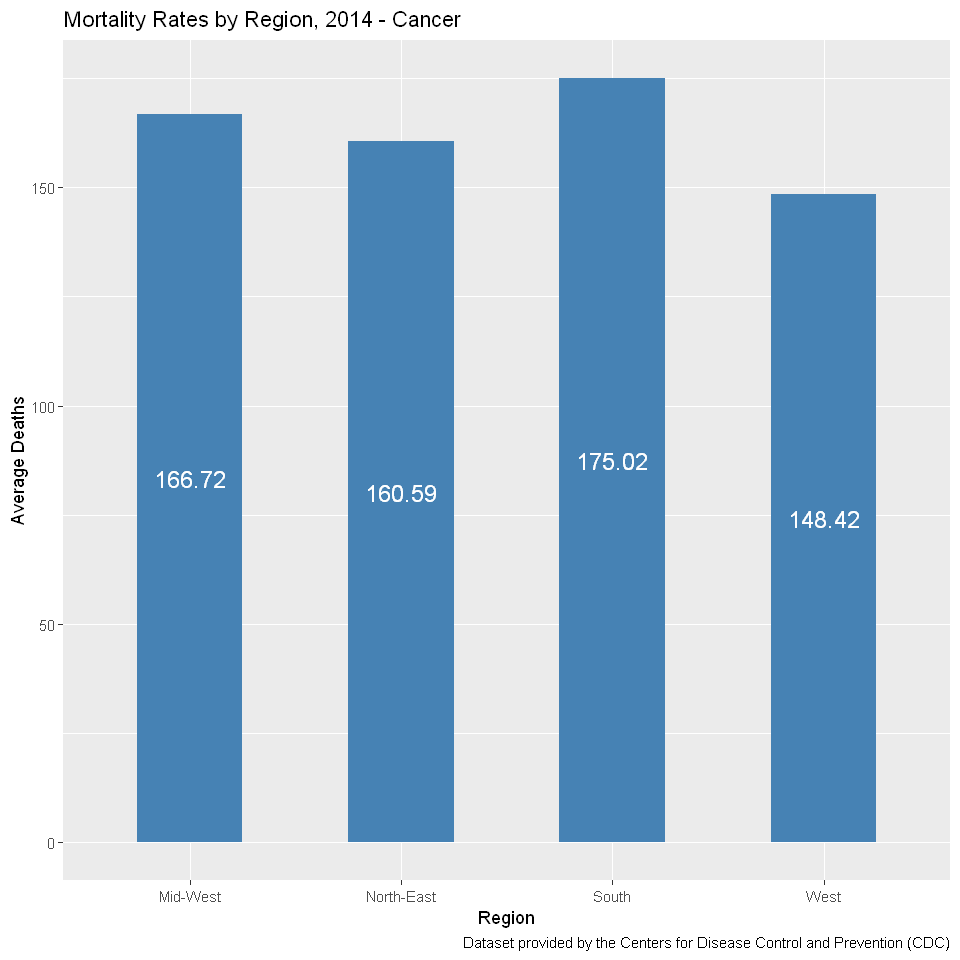

In [4]:
library(repr)
options(repr.plot.width=8, repr.plot.height=8)
ggplot(data=lcdr, aes_string(x="Region", y="Cancer_AVG")) + geom_bar(stat="identity", fill="steelblue", width=0.5) + labs(title="Mortality Rates by Region, 2014 - Cancer", caption="Dataset provided by the Centers for Disease Control and Prevention (CDC)",y="Average Deaths") + geom_text(aes(label=round(Cancer_AVG, digits=2)), position = position_stack(vjust=0.5), color="white", size=5)

In [125]:
trends <- read.df("C:/Users/jack_/Desktop/Big Data Project/output/search_trends_2015.csv", "csv", inferSchema = "true", header = "true", )
createOrReplaceTempView(trends, "trends")
s <- sql("select cancer_avg, '2015' as Year from trends where Region = 'South'")
w <- sql("select cancer_avg, '2015' as Year from trends where Region = 'West'")
ne <- sql("select cancer_avg, '2015' as Year from trends where Region = 'North-East'")
mw <- sql("select cancer_avg, '2015' as Year from trends where Region = 'Mid-West'")
createOrReplaceTempView(s, "s15")
createOrReplaceTempView(w, "w15")
createOrReplaceTempView(ne, "ne15")
createOrReplaceTempView(mw, "mw15")

In [85]:
south_searches <- sql("select * from s14 union select * from s15 union select * from s16 union select * from s17 union select * from s18")
west_searches <- sql("select * from w14 union select * from w15 union select * from w16 union select * from w17 union select * from w18")
northeast_searches <- sql("select * from ne14 union select * from ne15 union select * from ne16 union select * from ne17 union select * from ne18")
midwest_searches <- sql("select * from mw14 union select * from mw15 union select * from mw16 union select * from mw17 union select * from mw18")
south_searches_rdf <- collect(south_searches)
west_searches_rdf <- collect(west_searches)
northeast_searches_rdf <- collect(northeast_searches)
midwest_searches_rdf <- collect(midwest_searches)

In [118]:

south_totals <- sql("select 'Searches' as Category, Cancer_AVG, Year from south_searches union select 'Death Rate' as Death, Cancer_AVG, Year from south")
west_totals <- sql("select 'Searches' as Category, Cancer_AVG, Year from west_searches union select 'Death Rate' as Death, Cancer_AVG, Year from west")
northeast_totals <- sql("select 'Searches' as Category, Cancer_AVG, Year from northeast_searches union select 'Death Rate' as Death, Cancer_AVG, Year from northeast")
midwest_totals <- sql("select 'Searches' as Category, Cancer_AVG, Year from midwest_searches union select 'Death Rate' as Death, Cancer_AVG, Year from midwest")
south_rdf <- collect(south_totals)
west_rdf <- collect(west_totals)
northeast_rdf <- collect(northeast_totals)
midwest_rdf <- collect(midwest_totals)

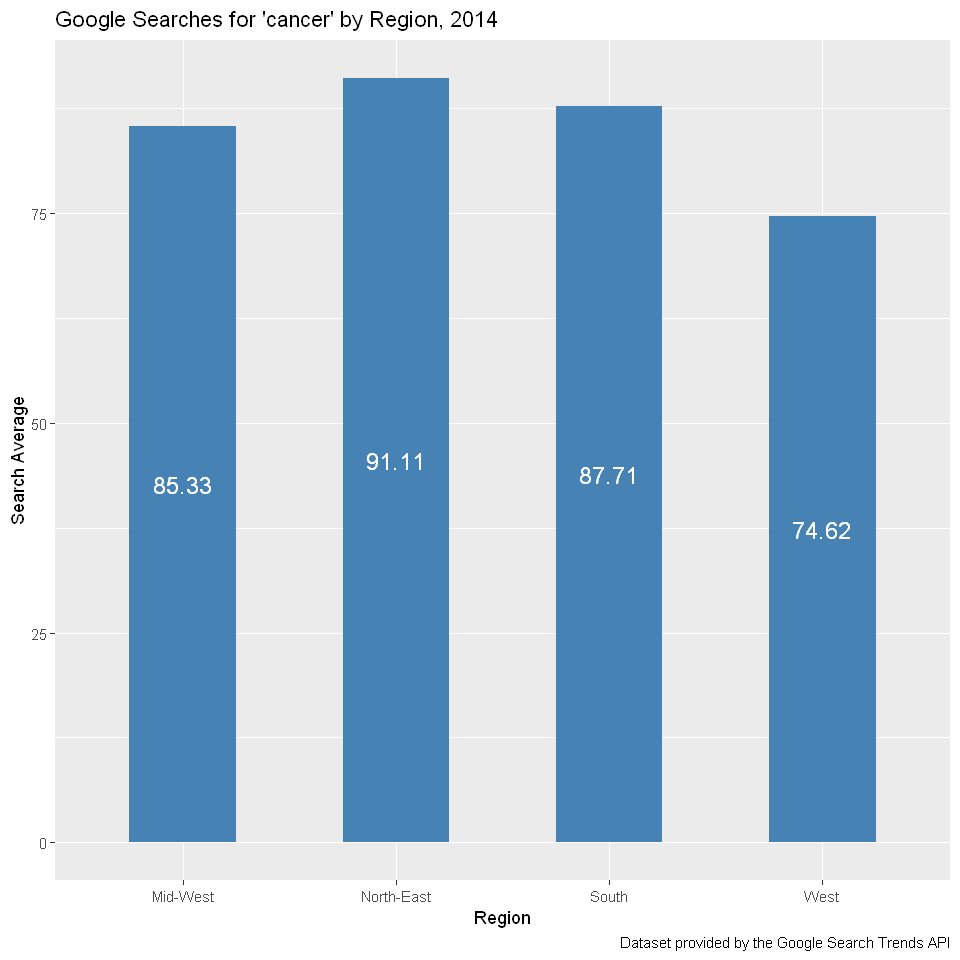

In [126]:
library(repr)
options(repr.plot.width=8, repr.plot.height=8)
ggplot(data=search_trends, aes_string(x="Region", y="cancer_avg")) + geom_bar(stat="identity", fill="steelblue", width=0.5) + labs(title="Google Searches for 'cancer' by Region, 2014", caption="Dataset provided by the Google Search Trends API", y="Search Average") + geom_text(aes(label=cancer_avg), position = position_stack(vjust=0.5), color="white", size=5)

In [128]:
added1 <- sql("select c.Region, 'C_Death' as Label, cast(c.cancer_avg as decimal(5,2)) as cancer_avg, c.cancer_avg + t.Cancer_AVG as cancer_sum from cancer_avg_by_reg c, trends t where c.Region = t.Region")
added2 <- sql("select t.Region, 'C_Search' as Label, cast(t.cancer_avg as decimal(5,2)) as cancer_avg, c.cancer_avg + t.Cancer_AVG as cancer_sum from cancer_avg_by_reg c, trends t where c.Region = t.Region")
createOrReplaceTempView(added1, 'added1')
createOrReplaceTempView(added2, 'added2')
joined <- sql("select Region, 'C_Death' as Label, cast(cancer_avg as decimal(5,2)) as cancer_avg, cast(cancer_sum as decimal(5,2)) as cancer_sum from added1 union select Region, 'C_Search' as Label, cast(Cancer_AVG as decimal(5,2)) as cancer_avg, cast(cancer_sum as decimal(5,2)) as cancer_sum from added2")
createOrReplaceTempView(joined, 'joined')
final <- collect(joined)
collect(joined)

,Region,Label,cancer_avg,cancer_sum
,<chr>,<chr>,<dbl>,<dbl>
1,Mid-West,C_Death,166.73,252.06
2,North-East,C_Death,160.59,251.70
3,Mid-West,C_Search,85.33,252.06
4,South,C_Search,87.71,262.73
5,South,C_Death,175.02,262.73
6,North-East,C_Search,91.11,251.70
7,West,C_Death,148.42,223.04
8,West,C_Search,74.62,223.04


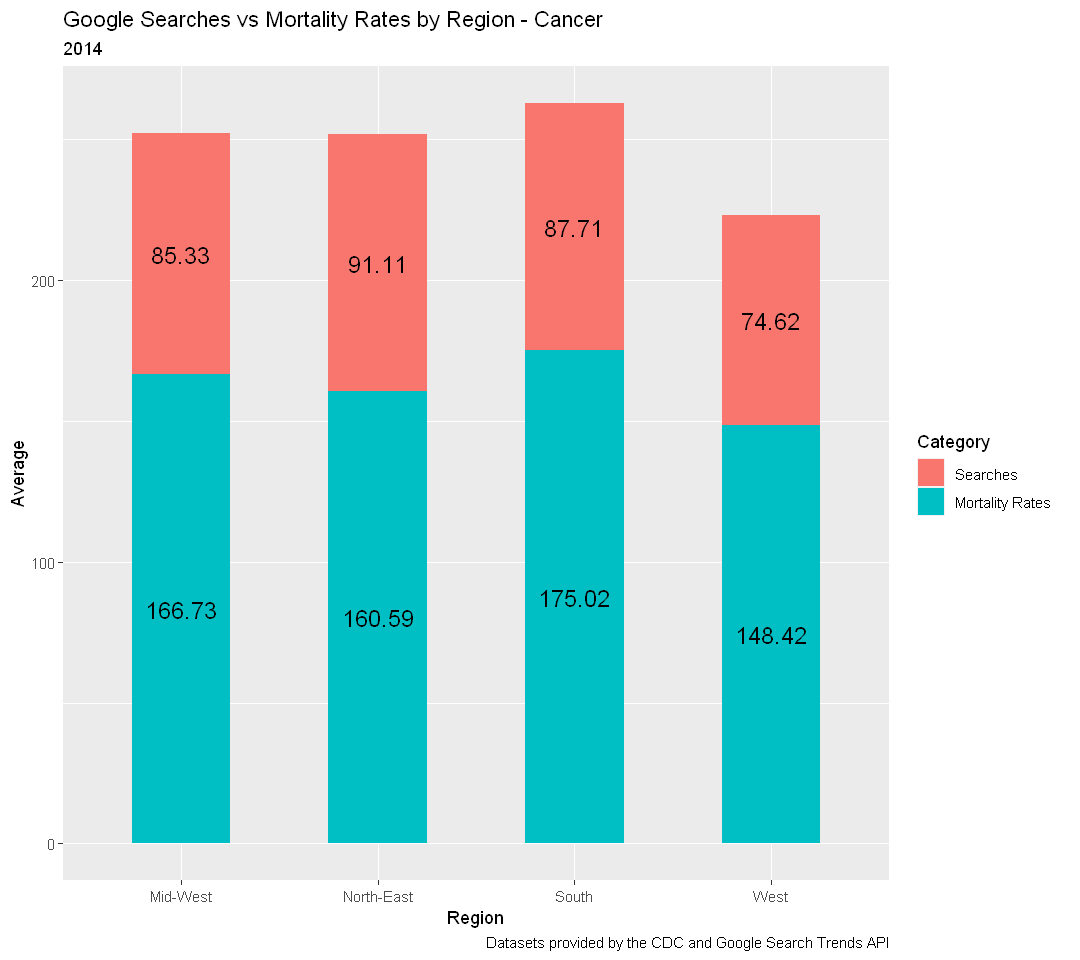

In [131]:
library(repr)
library(forcats)
options(repr.plot.width=9, repr.plot.height=8)
final$Label <- fct_rev(final$Label)
ggplot(data=final, aes_string(x="Region", y="cancer_avg", fill='Label')) + geom_bar(stat="identity", width=0.5) + geom_text(aes(label=cancer_avg), position = position_stack(vjust=0.5), color="black", size=5) + labs(title="Google Searches vs Mortality Rates by Region - Cancer", subtitle="2014", caption="Datasets provided by the CDC and Google Search Trends API", y="Average") + scale_fill_discrete(name = "Category", labels = c("Searches", "Mortality Rates"))

Warning message:
"Ignoring unknown aesthetics: digits"


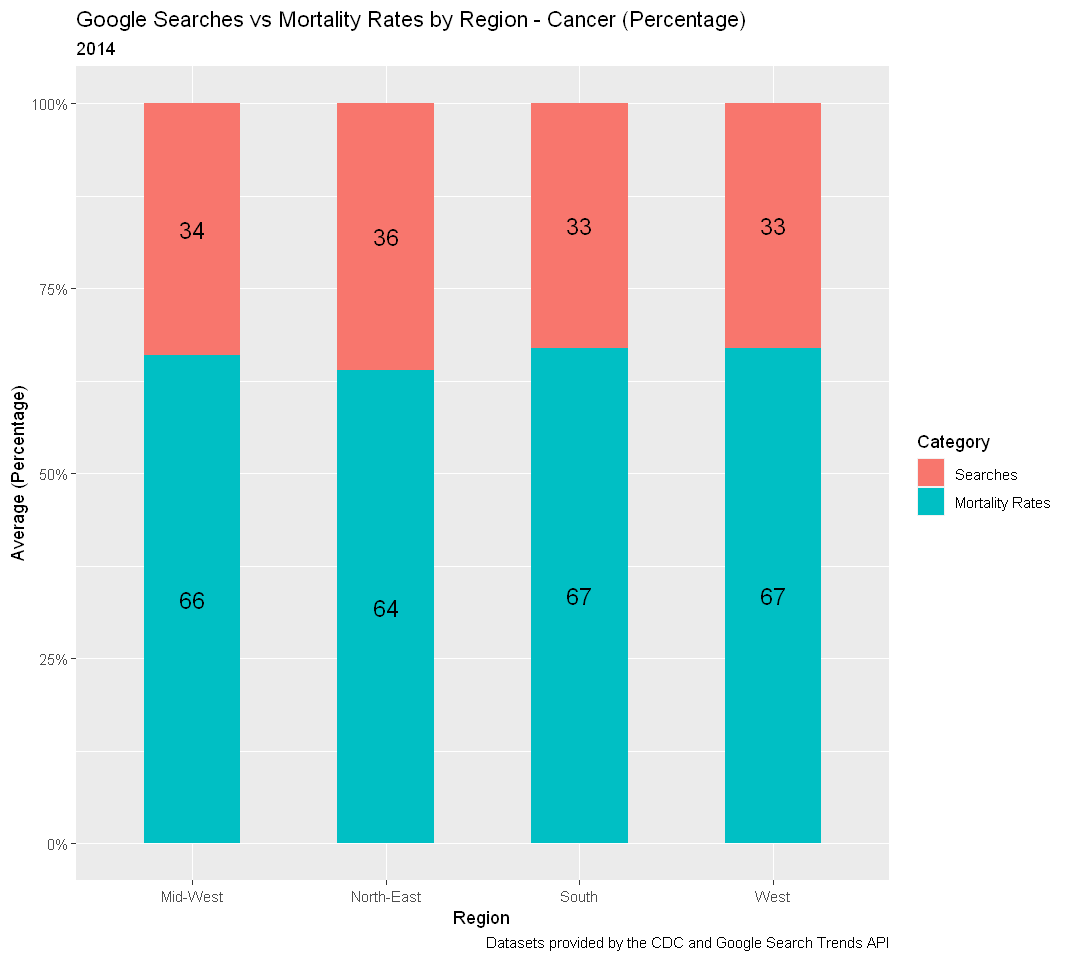

In [133]:
library(scales)
library(forcats)
options(repr.plot.width=9, repr.plot.height=8)
final$Label <- fct_rev(final$Label)
ggplot(data=final, aes(x=Region, y=round((cancer_avg/cancer_sum), digits=2), fill=Label)) + geom_bar(stat="identity", width=0.5) + geom_text(aes(label=round((cancer_avg/cancer_sum)*100), digits=2), position = position_stack(vjust=0.5), color="black", size=5) + labs(title="Google Searches vs Mortality Rates by Region - Cancer (Percentage)", subtitle="2014", caption="Datasets provided by the CDC and Google Search Trends API", y="Average (Percentage)") + scale_y_continuous(labels = percent_format(), limits=c(0,1)) + scale_fill_discrete(name = "Category", labels = c("Searches", "Mortality Rates"))

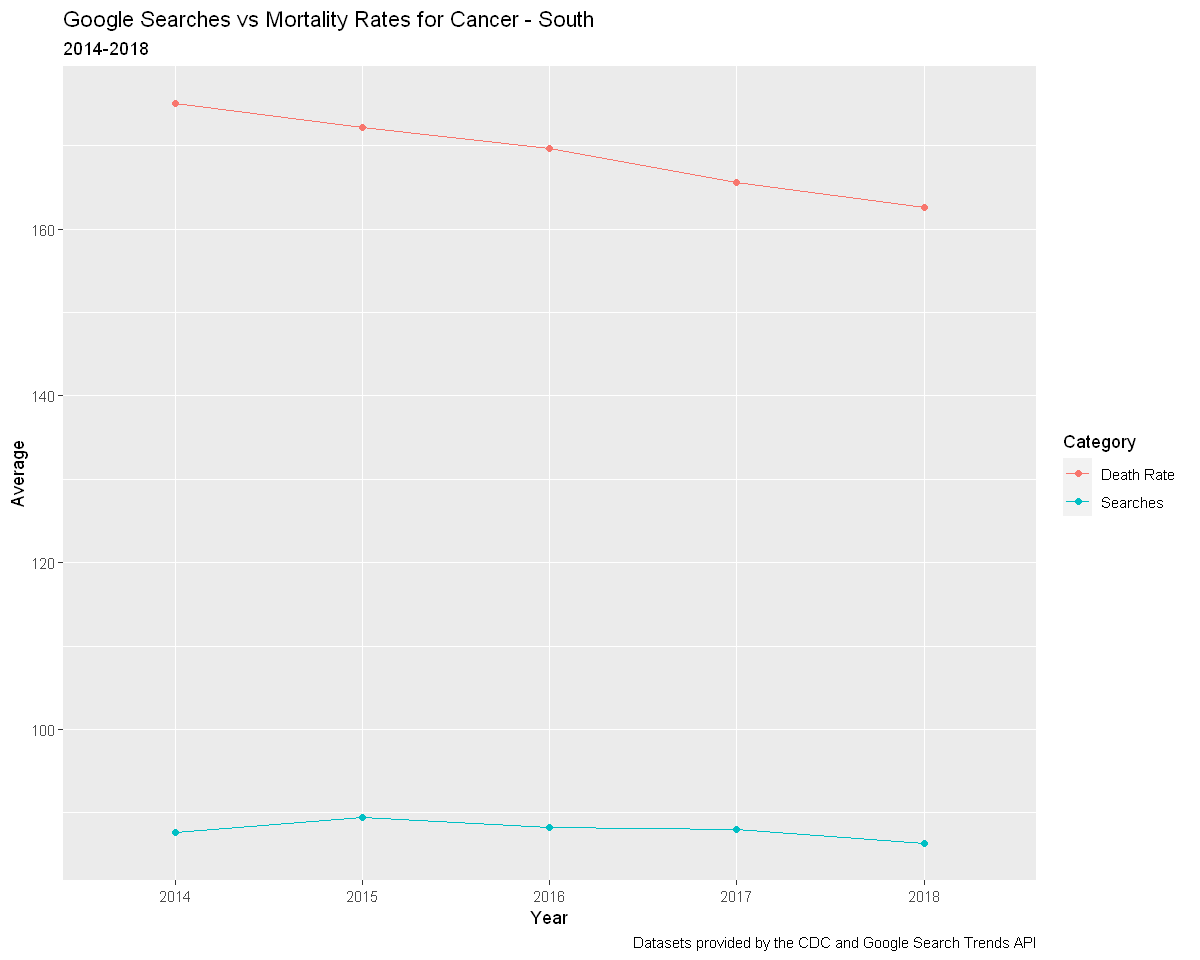

In [119]:
library(repr)
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data=south_rdf, aes(x=Year, y=Cancer_AVG, group=Category)) +
  geom_line(aes(color=Category))+
  geom_point(aes(color=Category)) +
labs(title="Google Searches vs Mortality Rates for Cancer - South", subtitle="2014-2018", caption="Datasets provided by the CDC and Google Search Trends API", y="Average")

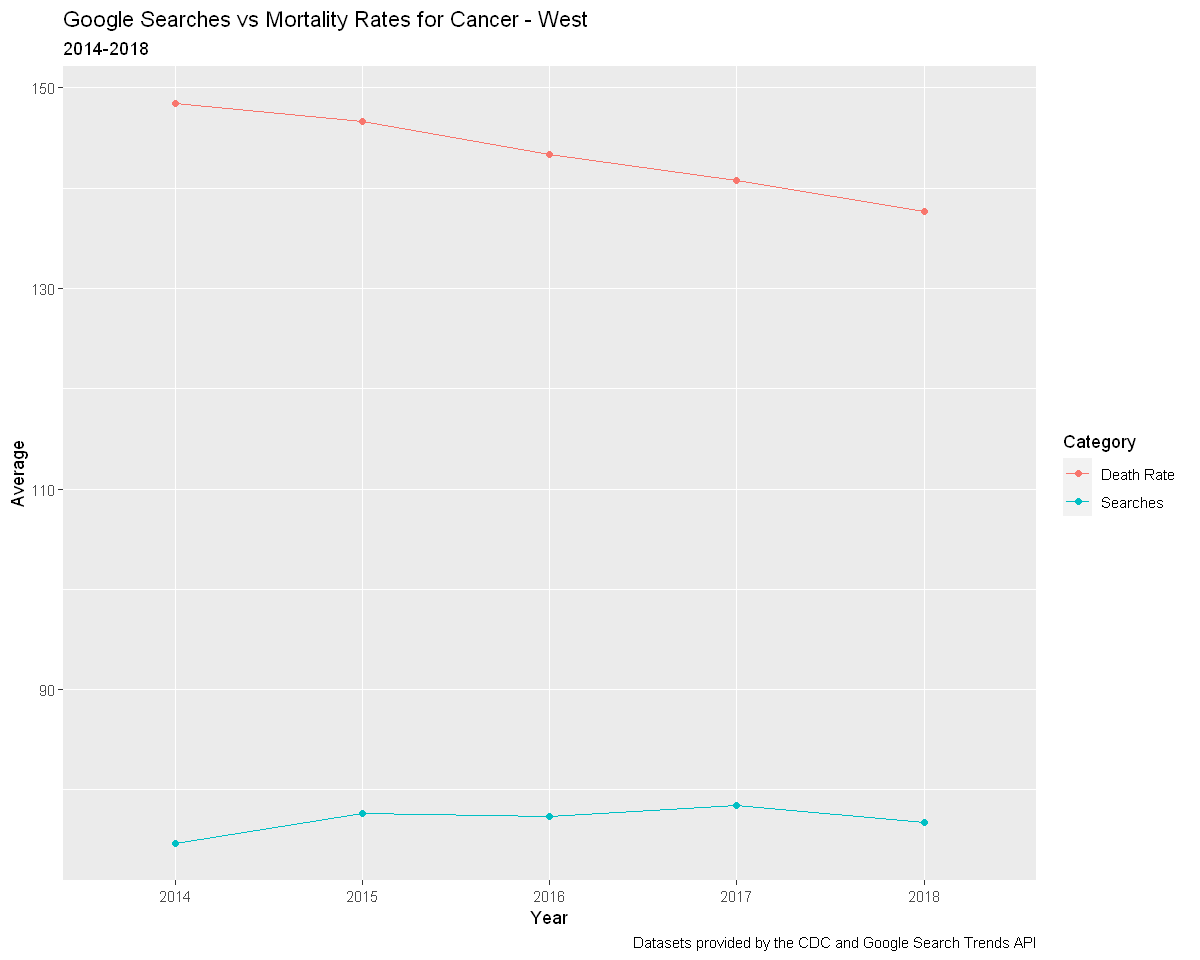

In [121]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data=west_rdf, aes(x=Year, y=Cancer_AVG, group=Category)) +
  geom_line(aes(color=Category))+
  geom_point(aes(color=Category)) +
    labs(title="Google Searches vs Mortality Rates for Cancer - West", subtitle="2014-2018", caption="Datasets provided by the CDC and Google Search Trends API", y="Average")

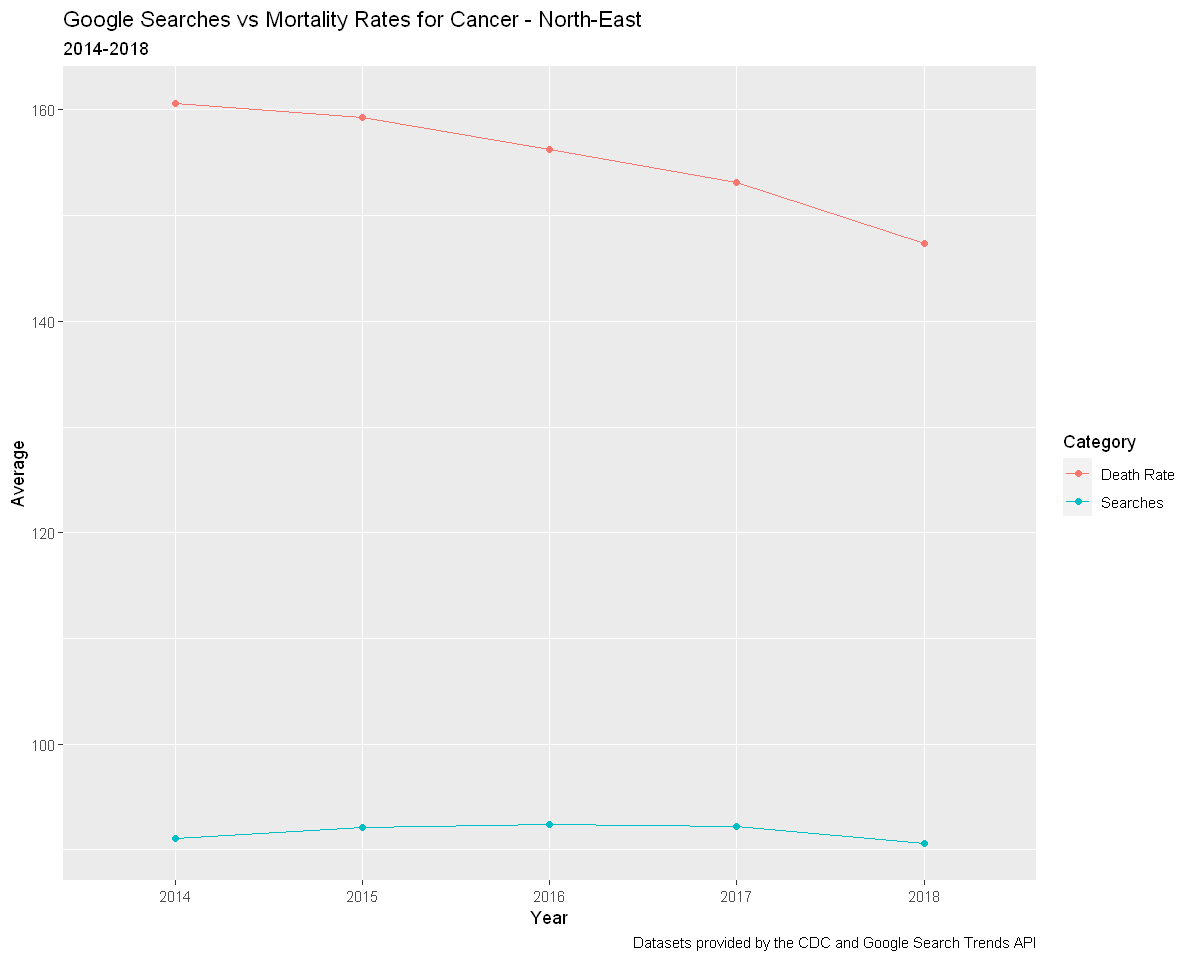

In [122]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data=northeast_rdf, aes(x=Year, y=Cancer_AVG, group=Category)) +
  geom_line(aes(color=Category))+
  geom_point(aes(color=Category)) +
labs(title="Google Searches vs Mortality Rates for Cancer - North-East", subtitle="2014-2018", caption="Datasets provided by the CDC and Google Search Trends API", y="Average")

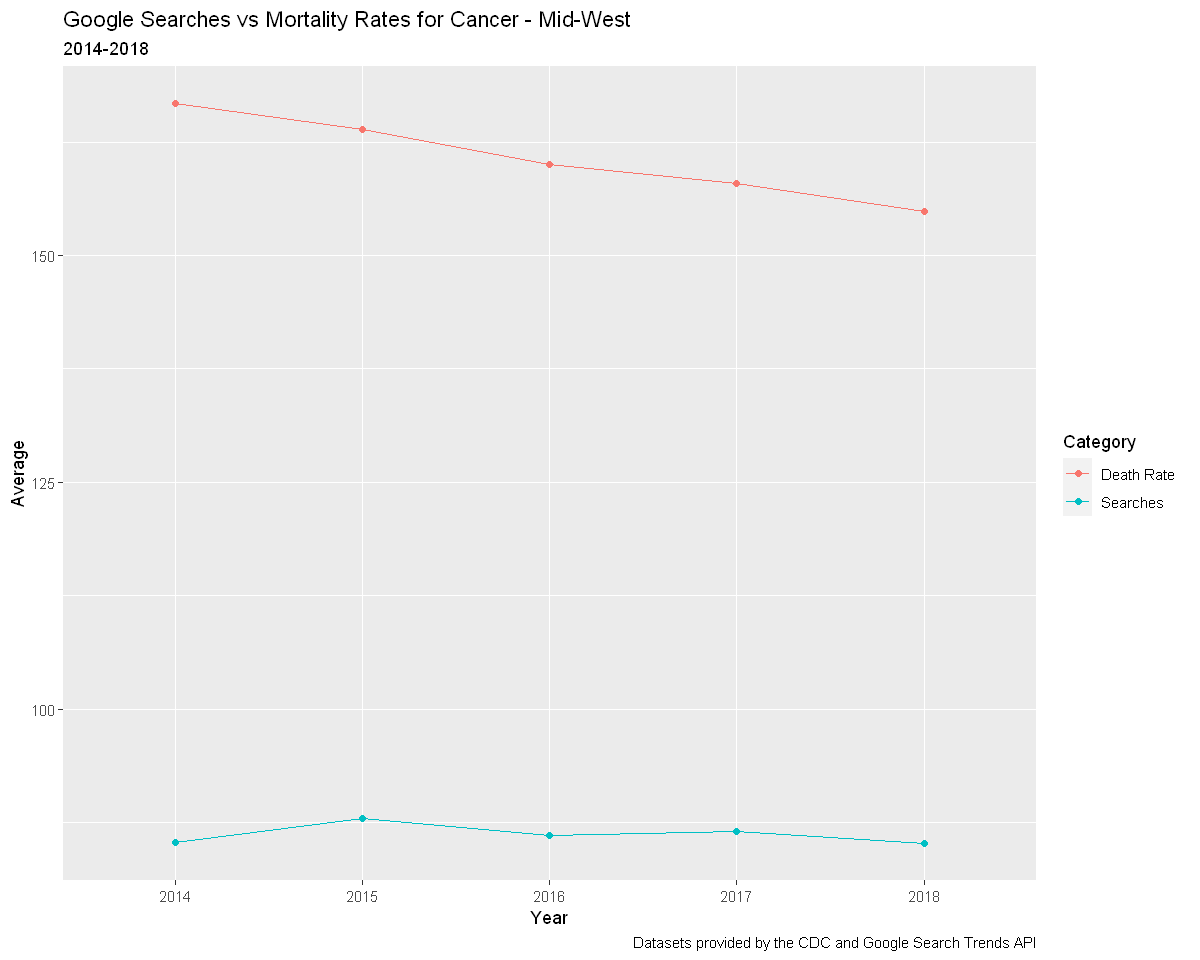

In [123]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data=midwest_rdf, aes(x=Year, y=Cancer_AVG, group=Category)) +
  geom_line(aes(color=Category))+
  geom_point(aes(color=Category)) +
labs(title="Google Searches vs Mortality Rates for Cancer - Mid-West", subtitle="2014-2018", caption="Datasets provided by the CDC and Google Search Trends API", y="Average")